In [1]:
%pip install laspy numpy matplotlib shapely

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os
import laspy
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

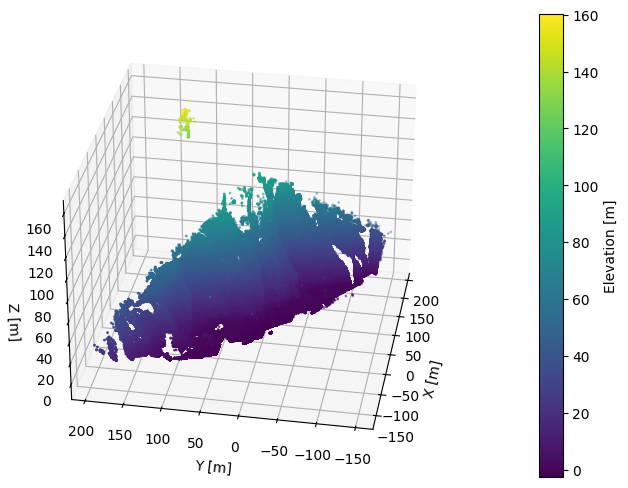

In [3]:
input_file = "/home/sam/Documents/datasets/WHU/3-Mountain/combined.las"

# Allow interactive rotation in notebook
%matplotlib inline

# Read the LAS file using laspy
las = laspy.read(input_file)

# Extract point cloud coordinates
x = las.x
y = las.y
z = las.z

# Create a figure with 3D axis
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

# Create a scatter plot of the point cloud
# Here, points are colored based on their elevation (z value)
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', s=1, marker='o')

# Label axes and add title
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")

# Set initial view of 3D plot
ax.view_init(elev=30.0, azim=190.0)

# Add a color bar to indicate elevation values
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Elevation [m]")

# Show the plot
plt.tight_layout()
plt.show()

Analytical ground truth volume removed (m^3): 12733.23900938511
Discrete approximation of volume removed (m^3): 14416.862982453666
Accuracy: 113.22227574482527 %
Ground truth transformation matrix (4x4):
[[ 9.53715498e-01 -3.00686851e-01  3.76381414e-03  1.00000000e+01]
 [ 3.00705342e-01  9.53697373e-01 -6.13332871e-03 -5.00000000e+00]
 [-1.74532837e-03  6.98124966e-03  9.99974108e-01  2.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


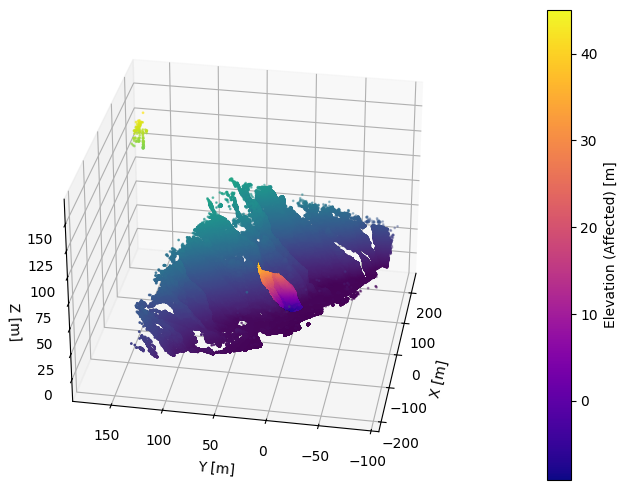

In [6]:
# Define the center and radius of the mining region
center_x = np.mean(x) + 15
center_y = np.mean(y) + 15
radius = 25              # adjust based on your dataset's scale
max_depth = 15           # maximum depth at the center

# Compute the distance from each point to the chosen center
d = np.sqrt((x - center_x)**2 + (y - center_y)**2)

# Create a mask for points within the mining region
mask = d < radius

# Use a Gaussian-like function to determine the deformation amount.
# The deformation is highest at the center and decreases towards the edges.
sigma = radius / 2.0  # controls the spread of the deformation
deformation = max_depth * np.exp(- (d**2) / (2 * sigma**2))

# Copy original z values and subtract deformation for points in the mining area
z_deformed = z.copy()
z_deformed[mask] -= deformation[mask]

# -------------------------------
# Analytical Volume Calculation
# -------------------------------
# The removed volume (V) is given by:
# V = 2π·σ²·max_depth · (1 – exp(–r²/(2σ²)))
analytical_volume = 2 * np.pi * sigma**2 * max_depth * (1 - np.exp(- (radius**2) / (2 * sigma**2)))
print("Analytical ground truth volume removed (m^3):", analytical_volume)

# -------------------------------
# Discrete (Point Cloud) Volume Approximation
# -------------------------------
# For the discrete approximation, assume the affected area (A) is πr².
# Then, if N points fall within the affected area, the average area per point is:
# ΔA = A / N
# The removed volume is approximated as the sum over affected points:
# V_discrete ≈ Σ (z_original - z_deformed) * ΔA
affected_area = np.pi * radius**2
N_affected = np.sum(mask)
delta_A = affected_area / N_affected
volume_discrete = np.sum(z[mask] - z_deformed[mask]) * delta_A
print("Discrete approximation of volume removed (m^3):", volume_discrete)

print("Accuracy:", volume_discrete / analytical_volume * 100, "%")

# Define a noise standard deviation (adjust as needed)
noise_std = 0.001 # 1 mm

# Add Gaussian noise to all coordinates
x_noisy = x + np.random.normal(loc=0, scale=noise_std, size=x.shape)
y_noisy = y + np.random.normal(loc=0, scale=noise_std, size=y.shape)
z_noisy = z_deformed + np.random.normal(loc=0, scale=noise_std, size=z_deformed.shape)

# Combine coordinates into a (N, 3) array
points = np.vstack((x_noisy, y_noisy, z_noisy)).T

# -------------------------------
# Specify Rotation and Translation Parameters
# -------------------------------
# Rotation angles in degrees (around x, y, and z axes)
angle_x_deg = 0.4  # rotation around x-axis
angle_y_deg = 0.1  # rotation around y-axis
angle_z_deg = 17.5 # rotation around z-axis

# Convert angles to radians
angle_x = np.deg2rad(angle_x_deg)
angle_y = np.deg2rad(angle_y_deg)
angle_z = np.deg2rad(angle_z_deg)

# Define individual rotation matrices
Rx = np.array([[1, 0, 0],
               [0, np.cos(angle_x), -np.sin(angle_x)],
               [0, np.sin(angle_x),  np.cos(angle_x)]])

Ry = np.array([[ np.cos(angle_y), 0, np.sin(angle_y)],
               [0, 1, 0],
               [-np.sin(angle_y), 0, np.cos(angle_y)]])

Rz = np.array([[np.cos(angle_z), -np.sin(angle_z), 0],
               [np.sin(angle_z),  np.cos(angle_z), 0],
               [0, 0, 1]])

# Combine the rotations (order: first Rx, then Ry, then Rz)
R = Rz @ Ry @ Rx

# Optional: specify translation on x, y, and z
tx, ty, tz = 10, -5, 0.2
translation = np.array([tx, ty, tz])

# -------------------------------
# Compute the 4x4 Transformation Matrix and Print It
# -------------------------------
T = np.eye(4)
T[:3, :3] = R
T[:3, 3] = translation
print("Ground truth transformation matrix (4x4):")
print(T)

# -------------------------------
# Apply Rotation and Translation
# -------------------------------
# Apply rotation (note: using R.T to rotate each point in rows)
points_rotated = points @ R.T
# Apply translation
points_transformed = points_rotated + translation

# Extract transformed coordinates
x_trans = points_transformed[:, 0]
y_trans = points_transformed[:, 1]
z_trans = points_transformed[:, 2]

# Create a 3D scatter plot of the deformed point cloud
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

# Plot unaffected points (using 'viridis' colormap based on z)
scatter_unaffected = ax.scatter(x_trans[~mask], y_trans[~mask], z_trans[~mask],
                                c=z_trans[~mask], cmap='viridis', s=1, marker='o')

# Plot affected points (using 'plasma' colormap based on z)
scatter_affected = ax.scatter(x_trans[mask], y_trans[mask], z_trans[mask],
                              c=z_trans[mask], cmap='plasma', s=1, marker='o')

# Label axes and set view
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=30.0, azim=190.0)

# Add separate colorbars to indicate elevation values for each region
cbar2 = plt.colorbar(scatter_affected, ax=ax, pad=0.1)
cbar2.set_label("Elevation (Affected) [m]")

plt.tight_layout()
plt.show()

In [ ]:
# Overwrite the original coordinates in the 'las' object
las.x = x_trans
las.y = y_trans
las.z = z_trans

# Finally, write the result to a new file
out_file = "/home/sam/Documents/datasets/WHU/3-Mountain/combined_deformed.las"
las.write(out_file)